# Import Library

In [3]:
# read, resize, plotting, splitting, encoding
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

# modelling
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.models import Sequential, load_model, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# evaluation
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

# Import Dataset
> Dataset yang digunakan adalah data gambar pion catur yang terdiri dari King, Queen, Bishop, Knight, Pawn, dan Rook, yang diambil dari Kaggle

Link Dataset = https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset

In [207]:
import os
data_dir = 'Chess'
os.listdir(data_dir)


['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']

In [208]:
#load images
images = []
labels = []

for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            image = cv2.imread(image_path)
            if image is None:
                print(f'Failed to read image: {image_path}')  # Debugging: cetak pesan jika gagal
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (180, 180))
            images.append(image)
            labels.append(folder_name)

images = np.array(images)
labels = np.array(labels)

print(f'Total images: {len(images)}')
print(f'Total labels: {len(labels)}')

Failed to read image: Chess\Bishop\00000095.gif
Total images: 555
Total labels: 555


In [209]:
# melihat jumlah data dan ukurannya
print('Images Shape :',images.shape)
print('Labels Shape :',labels.shape)

Images Shape : (555, 180, 180, 3)
Labels Shape : (555,)


In [210]:
# melihat jumlah data setiap kelasnyaa
lab = pd.DataFrame({'labels':labels})
lab.value_counts()

labels
Pawn      107
Knight    106
Rook      102
Bishop     86
Queen      78
King       76
dtype: int64

Augmentasi

In [211]:
import imgaug.augmenters as iaa

data_gambar = images # array Numpy dari gambar-gambar
label = labels  # label untuk setiap gambar

# Hitung jumlah gambar untuk setiap kelas
jumlah_per_kelas = {}
for l in label:
    if l not in jumlah_per_kelas:
        jumlah_per_kelas[l] = 0
    jumlah_per_kelas[l] += 1

# Tentukan jumlah gambar yang diinginkan setelah augmentasi untuk setiap kelas
target_jumlah = 300  

# Tentukan augmenter
aug = iaa.Sequential([
    iaa.Fliplr(),
    iaa.Affine(rotate=(-30, 30))# Tambahkan transformasi
])

# Lakukan augmentasi untuk setiap kelas
for kelas, jumlah in jumlah_per_kelas.items():
    if jumlah < target_jumlah:
        # Filter gambar yang sesuai dengan kelas
        gambar_kelas_ini = data_gambar[label == kelas]

        # Hitung berapa banyak gambar yang perlu ditambahkan
        tambahan = target_jumlah - jumlah

        # Lakukan augmentasi sejumlah tambahan gambar yang dibutuhkan
        augmented_images = []
        for i in range(tambahan):
            # Ambil gambar acak dari kelas ini
            img = gambar_kelas_ini[np.random.randint(0, jumlah)]

            # Lakukan augmentasi pada gambar
            augmented_img = aug.augment_image(img)

            # Simpan gambar hasil augmentasi
            augmented_images.append(augmented_img)

        # Tambahkan gambar-gambar hasil augmentasi ke data gambar dan label
        data_gambar = np.concatenate((data_gambar, np.array(augmented_images)))
        label = np.concatenate((label, np.array([kelas] * tambahan)))



In [212]:
images = data_gambar
labels = label

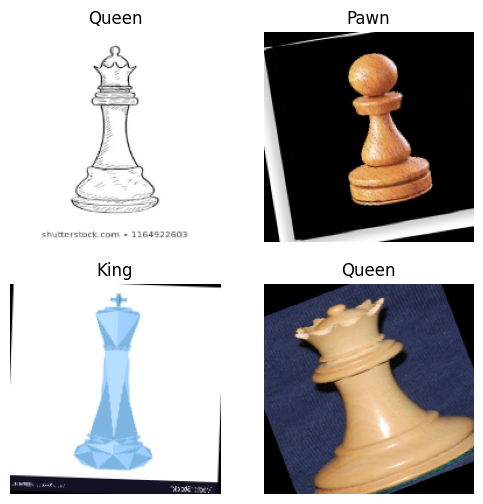

In [213]:
#tampilkan gambar 
plt.figure(figsize=(6,6))
x = 1
for i in np.random.randint(0,len(images),4):
    plt.subplot(2, 2, x)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')
    x += 1

In [214]:
# label encoding dan save ke joblib
le=LabelEncoder()
labels=le.fit_transform(labels)

joblib.dump(le, 'label_encoder.joblib')

['label_encoder.joblib']

In [215]:
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=32, stratify=labels)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.50, random_state=32, stratify=y_test)

In [216]:
# Periksa bentuk data
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}')
print(f'y_val shape: {y_val.shape}')

# Pastikan data dan label sesuai
import numpy as np

num_classes = len(np.unique(y_train))  # Pastikan jumlah kelas benar

print(f'Number of classes: {num_classes}')

x_train shape: (1260, 180, 180, 3)
y_train shape: (1260,)
x_val shape: (270, 180, 180, 3)
y_val shape: (270,)
Number of classes: 6


In [217]:
from tensorflow.keras.applications import EfficientNetV2M #klasifikasi gambar menggunakan efficient net 
base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(180,180,3), pooling='max')

#nonaktifkan training pada lapisan dasar
for layer in base_model.layers:
    layer.trainable = False

#menambahkan lapisan kustom
x = base_model.output
x = Dense(2048, activation='relu')(x)
x = Dropout(0.3) (x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

#menambahkan lapisan keluaran
predictions = Dense(num_classes, activation='softmax')(x)

#membuat model
model = Model(inputs=base_model.input, outputs=predictions)

#mengkompile model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [218]:
#train model
earlystop = EarlyStopping(patience=2, restore_best_weights=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics='accuracy')
hist = model.fit(x_train, y_train, epochs=30, validation_data=(x_val,y_val), callbacks=earlystop, batch_size=256)

Epoch 1/30
5/5 [==============================] - 24s 2s/step - loss: 6.2974 - accuracy: 0.2000 - val_loss: 1.7571 - val_accuracy: 0.2926
Epoch 2/30
5/5 [==============================] - 5s 1s/step - loss: 1.8130 - accuracy: 0.2976 - val_loss: 1.5619 - val_accuracy: 0.3407
Epoch 3/30
5/5 [==============================] - 5s 1s/step - loss: 1.4955 - accuracy: 0.3421 - val_loss: 1.2685 - val_accuracy: 0.4852
Epoch 4/30
5/5 [==============================] - 5s 1s/step - loss: 1.1683 - accuracy: 0.5413 - val_loss: 1.0226 - val_accuracy: 0.5519
Epoch 5/30
5/5 [==============================] - 5s 1s/step - loss: 0.9978 - accuracy: 0.6056 - val_loss: 0.9402 - val_accuracy: 0.6185
Epoch 6/30
5/5 [==============================] - 5s 1s/step - loss: 0.9059 - accuracy: 0.6270 - val_loss: 0.8540 - val_accuracy: 0.6407
Epoch 7/30
5/5 [==============================] - 5s 1s/step - loss: 0.7963 - accuracy: 0.6873 - val_loss: 0.7670 - val_accuracy: 0.6963
Epoch 8/30
5/5 [========================

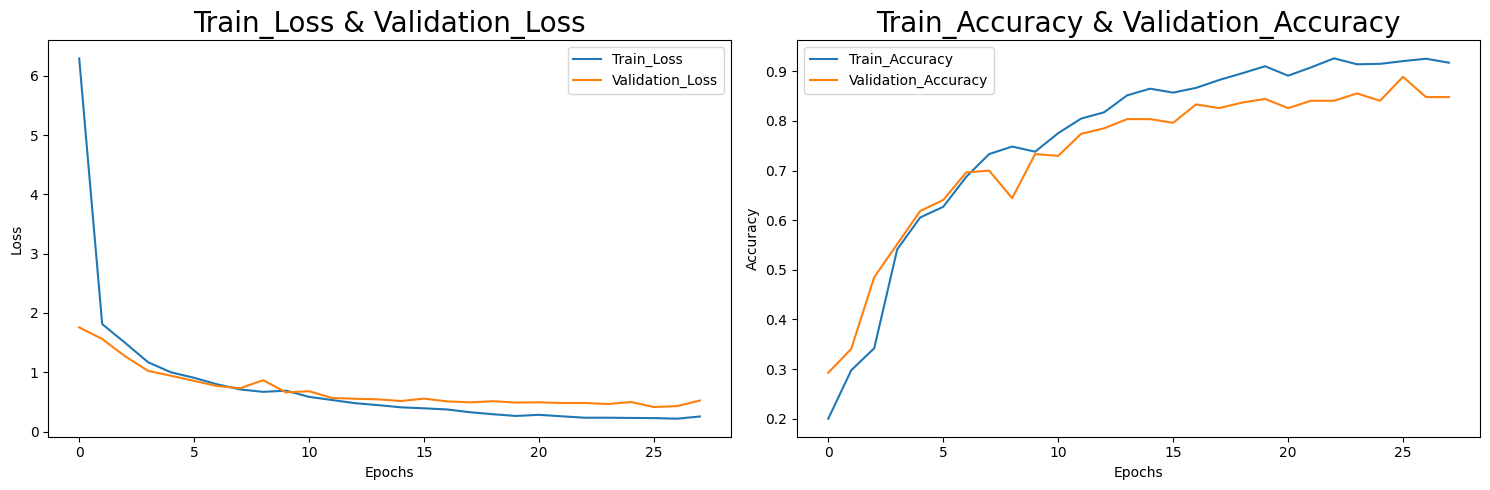

In [219]:
# melihat hasil training
hist_=pd.DataFrame(hist.history)
plt.figure(figsize=(15, 5))

# train loss dan validation loss berdasarkan epoch
plt.subplot(1, 2, 1)
plt.plot(hist_['loss'], label='Train_Loss')
plt.plot(hist_['val_loss'], label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# train accuracy dan validation accuracy berdasarkan epoch
plt.subplot(1, 2, 2)
plt.plot(hist_['accuracy'], label='Train_Accuracy')
plt.plot(hist_['val_accuracy'], label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [220]:
# fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True
model.compile(optimizer=Adam(lr=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [221]:
# retrain sebagian layer 
earlystop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics='accuracy')
hist = model.fit(x_train, y_train, epochs=30, validation_data=(x_val,y_val), callbacks=[checkpoint, earlystop], batch_size=256)

Epoch 1/30
5/5 [==============================] - 26s 3s/step - loss: 3.5210 - accuracy: 0.5897 - val_loss: 1.7564 - val_accuracy: 0.6593
Epoch 2/30
5/5 [==============================] - 7s 2s/step - loss: 0.6803 - accuracy: 0.7690 - val_loss: 0.6360 - val_accuracy: 0.8000
Epoch 3/30
5/5 [==============================] - 7s 2s/step - loss: 0.4375 - accuracy: 0.8778 - val_loss: 0.4911 - val_accuracy: 0.8296
Epoch 4/30
5/5 [==============================] - 8s 2s/step - loss: 0.2401 - accuracy: 0.9270 - val_loss: 0.2701 - val_accuracy: 0.9111
Epoch 5/30
5/5 [==============================] - 7s 2s/step - loss: 0.1543 - accuracy: 0.9556 - val_loss: 0.2613 - val_accuracy: 0.9333
Epoch 6/30
5/5 [==============================] - 7s 2s/step - loss: 0.1077 - accuracy: 0.9619 - val_loss: 0.2478 - val_accuracy: 0.9333
Epoch 7/30
5/5 [==============================] - 9s 2s/step - loss: 0.0906 - accuracy: 0.9706 - val_loss: 0.2399 - val_accuracy: 0.9407
Epoch 8/30
5/5 [========================

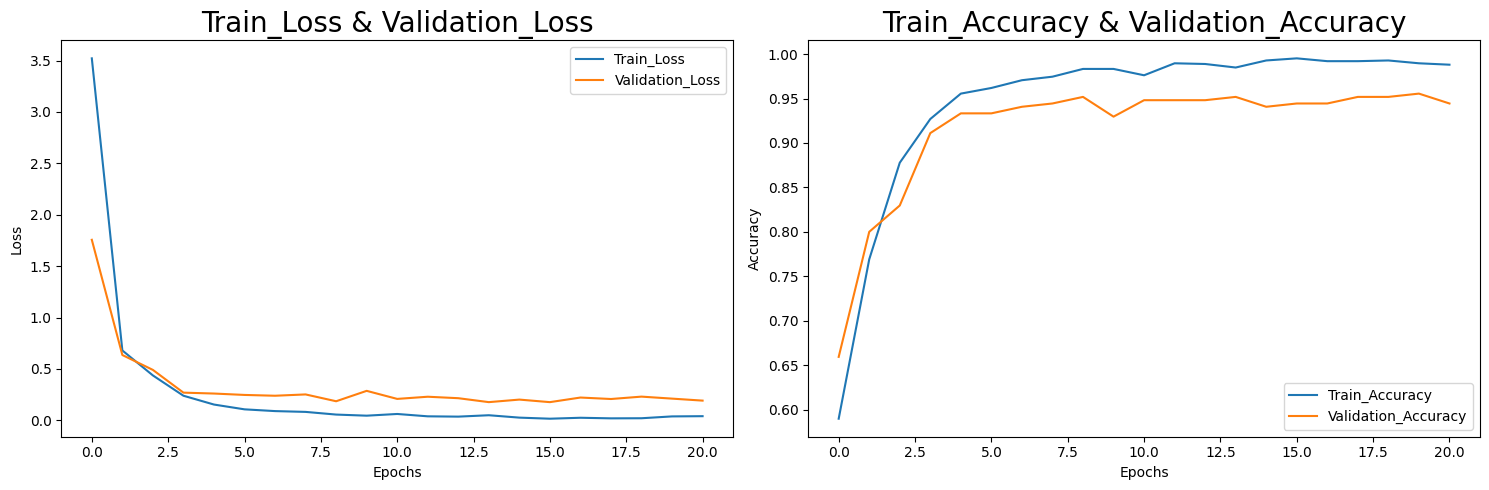

In [222]:
#melihat hasil retrain sebagian layer 
hist_=pd.DataFrame(hist.history)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_['loss'], label='Train_Loss')
plt.plot(hist_['val_loss'], label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_['accuracy'], label='Train_Accuracy')
plt.plot(hist_['val_accuracy'], label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
#load model
model = load_model('best_model.h5')

In [224]:
#lihat score accuracy data test
score, acc = model.evaluate(x_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

9/9 [==============================] - 4s 84ms/step - loss: 0.1478 - accuracy: 0.9667
Test Loss = 0.1478312611579895
Test Accuracy = 0.9666666388511658


In [225]:
#membuat prediksi dengan data test 
prediction = model.predict(x_test)
y_pred=np.argmax(prediction, axis=1)
df=pd.DataFrame()
df['Actual'],df['Prediction']=le.inverse_transform(y_test),le.inverse_transform(y_pred)
df.head(20)

9/9 [==============================] - 4s 100ms/step


,Actual,Prediction
0,Rook,Rook
1,Bishop,Bishop
2,Bishop,Bishop
3,Rook,Rook
4,Knight,Knight
5,Pawn,Pawn
6,Queen,Queen
7,Pawn,Pawn
8,Pawn,Pawn
9,King,King


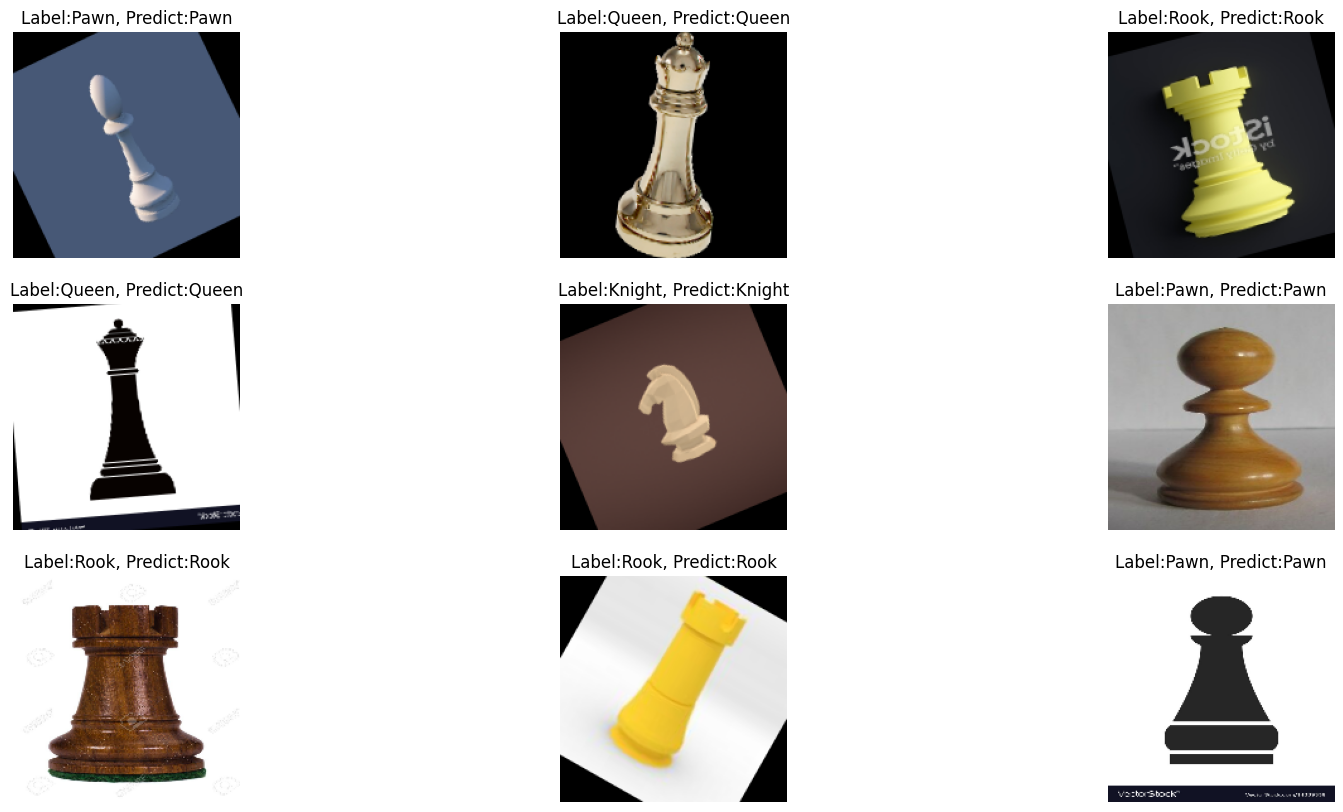

In [226]:
#tampilkan gambar acak dari dataset
y_test2=le.inverse_transform(y_test)
y_pred2=le.inverse_transform(y_pred)
plt.figure(figsize=(20,10))
x = 1
for i in np.random.randint(0,len(x_test),9):
    plt.subplot(3, 3, x)
    plt.imshow(x_test[i])
    plt.title(f'Label:{y_test2[i]}, Predict:{y_pred2[i]}', fontsize=12)
    plt.axis('off')
    x += 1

In [227]:
print(classification_report(y_test,y_pred)) #evaluasi model

              precision    recall  f1-score   support

           0       0.94      0.98      0.96        45
           1       1.00      0.84      0.92        45
           2       1.00      1.00      1.00        45
           3       1.00      0.98      0.99        45
           4       0.94      1.00      0.97        45
           5       0.94      1.00      0.97        45

    accuracy                           0.97       270
   macro avg       0.97      0.97      0.97       270
weighted avg       0.97      0.97      0.97       270



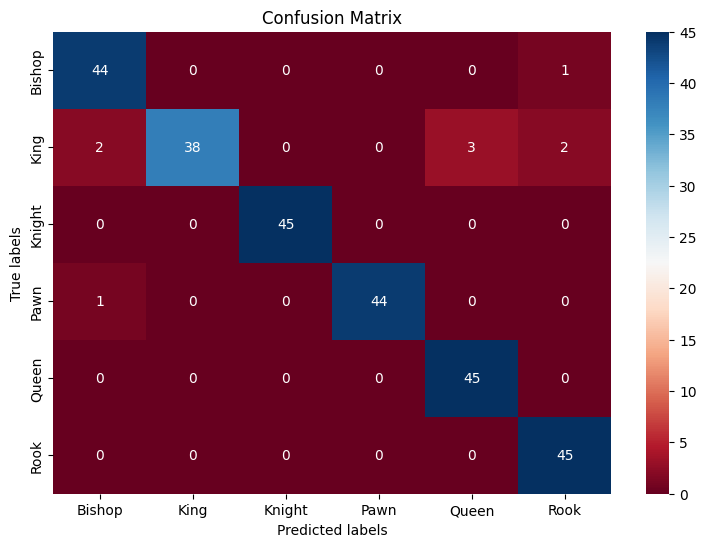

In [228]:
#Confussion Matrix
y_test_original = le.inverse_transform(y_test)
y_pred_original = le.inverse_transform(y_pred)

CM = confusion_matrix(y_test_original, y_pred_original)

class_labels = le.classes_

plt.figure(figsize=(9, 6))
sns.heatmap(CM, annot=True, fmt='g', cmap='RdBu', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Berdasarkan visualisasi confussion matrix diatas, diketahui model sudah cukup baik mengklaisifikasikan data. Hanya beberapa data yang mengalami kesalahan labeling, seperti pion Queen yang diprediksi menjadi King.

# Predict An Image

1/1 [==============================] - 6s 6s/step


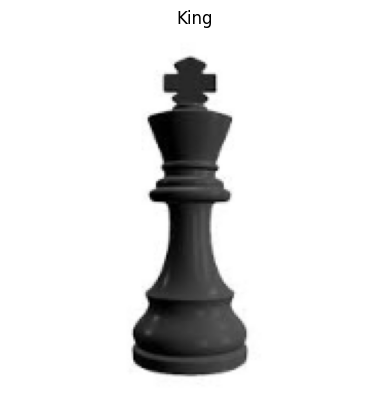

In [5]:
# model = load_model('model.h5')
le = joblib.load('label_encoder.joblib')

img = cv2.imread('king.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
resize = cv2.resize(img, (180, 180))

pred = model.predict(resize[np.newaxis])
predicted_class = np.argmax(pred)

predicted_label = le.inverse_transform([predicted_class])

plt.title(predicted_label[0])
plt.imshow(resize)
plt.axis('off')
plt.show()
